In [15]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import math
from sklearn.linear_model import LinearRegression
import figurefirst as fifi
sys.path.append('../utils_2')
import figure_functions as ff
from pybounds import SlidingEmpiricalObservabilityMatrix, SlidingFisherObservability, colorline
sys.path.append('../model')
from drone_model_with_PWM import DroneSimulator
from drone_model_with_PWM import DroneModel
from drone_model_with_PWM import DroneParameters
sys.path.append('../EKF')
from ekf import ekf as EKF
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# set the parameters for your system

In [16]:
g = 9.81  # gravity [m/s^2]
m = 0.086  # mass [kg]
M = 2.529  # mass [kg]
Mm = 4 * m + M  # total mass [kg]
L = 0.2032  # length [m]
R = 0.1778  # average body radius [m]
I_x = .491
# self.I_x = 2 * (self.M * self.R ** 2) / 5 + 2 * self.m * self.L ** 2  # [kg*m^2] moment of inertia about x
I_y = .387
# self.I_y = 2 * (self.M * self.R ** 2) / 5 + 2 * self.m * self.L ** 2  # [kg*m^2] moment of inertia about y
I_z = .667
# self.I_z = 2 * (self.M * self.R ** 2) / 5 + 4 * self.m * self.L ** 2  # [kg*m^2] moment of inertia about y
# b = 1.8311  # thrust coefficient
# d = 1  # drag constant
# C = 0.1  # drag coefficient from ground speed plus air speed
b = 1.34
d = 1.0
C = 0.1

PARAMS = {
        'g': g,
        'm': m,
        'M': M,
        'Mm': Mm,
        'L': L,
        'R': R,
        'I_x': I_x,
        'I_y': I_y,
        'I_z': I_z,
        'b': b,
        'd': d,
        'C': C
                }

# Build the trajectory set points to go into MPC

In [17]:
dt = 0.1  # sampling time [s]
fs = 1 / dt  # sampling frequency [hz]
T = 11.0  # total time [s]
tsim = np.arange(0, T + dt/2, step=dt) # time vector [s]
g0 = 1.0
t0 = 1.0
v_x =  g0 * np.ones_like(tsim) + 0.0 * tsim
v_y =  0.0 * np.ones_like(tsim) + 0.0 * tsim
psi = (-np.pi/4) * np.ones_like(tsim)
psi_global = -(np.pi/4) * np.ones_like(tsim)
index = int((0.5 + t0) * fs)
v_x[index:] = v_x[index] - 3*g0/4
index = int((3.0 + t0) * fs)
v_x[index:] = v_x[index] + 3*g0/4
index = int((4.0 + t0) * fs)
psi[index:] = psi[index] + np.pi/2
index = int((6.9 + t0) * fs)
psi[index:] = psi[index] + np.pi/1.3
index = int((8.0 + t0) * fs)
tsim_temp = tsim[index:]
tsim_temp = tsim_temp - tsim_temp[0]
psi_temp = -(np.pi/3)*np.sin(2*np.pi*0.6*tsim_temp + np.pi/2) + 0.0*(np.pi/6)*np.cos(2*np.pi*1.0*tsim_temp + np.pi/3)
psi_temp = psi_temp - psi_temp[0]
# psi_temp = util.wrapTo2Pi(psi_temp)
psi[index:] = psi[index] + psi_temp
index = int((8.0 + t0) * fs)
psi[index:] = psi[index:] + np.pi/2
# Global course
x_dot = v_x * np.cos(psi_global) + v_y * np.sin(psi_global)
y_dot = v_x * np.sin(psi_global) + v_y * np.cos(psi_global)
index = int((5.5 + t0) * fs)
psi_global[index:] = psi_global[index] - np.pi/2
index = int((6.9 + t0) * fs)
psi_global[index:] = psi_global[index] + np.pi/2
# index = int((7.5 + t0) * fs)
# psi_global[index:] = psi_global[index] + np.pi
v_x = x_dot * np.cos(psi_global) + y_dot * np.sin(psi_global)
v_y = y_dot * np.cos(psi_global) - x_dot * np.sin(psi_global)
z= 2 * np.ones_like(v_x)

# get x0_sim for states x, y, z, v_x, v_y, v_z, phi, theta, psi, omega_x, omega_y, omega_z, wx, wy
X0_sim = np.array([0, 0, z[0], v_x[0], v_y[0], 0, 0, 0, psi[0], 0, 0, 0, 0, 0])
# Check if the absolute values of the last two elements are both < 1e-12
if abs(X0_sim[-1]) < 1e-12 and abs(X0_sim[-2]) < 1e-12:
    print('hello')
    X0_sim[-2] = 1e-12
    X0_sim[-1] = 1e-12
print("X0_sim", len(X0_sim), '\n', X0_sim)

hello
X0_sim 14 
 [ 0.00000000e+00  0.00000000e+00  2.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.85398163e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e-12  1.00000000e-12]


# run MPC

In [18]:
# Create simulator
simulator = DroneSimulator(dt=dt, mpc_horizon=50, r_u=1e-4, control_mode='velocity_body_level',params=PARAMS)
# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, wx=np.zeros_like(z), wy=np.zeros_like(z))
# Run simulation
st = time.time()
# t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=X0_sim, u=U_real, mpc=False, return_full_output=True)
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=X0_sim, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

Drone parameters: {'g': 9.81, 'm': 0.086, 'M': 2.529, 'Mm': 2.8729999999999998, 'L': 0.2032, 'R': 0.1778, 'I_x': 0.491, 'I_y': 0.387, 'I_z': 0.667, 'b': 1.34, 'd': 1.0, 'C': 0.1}
elapsed time: 38.86653995513916


# plot trajectory

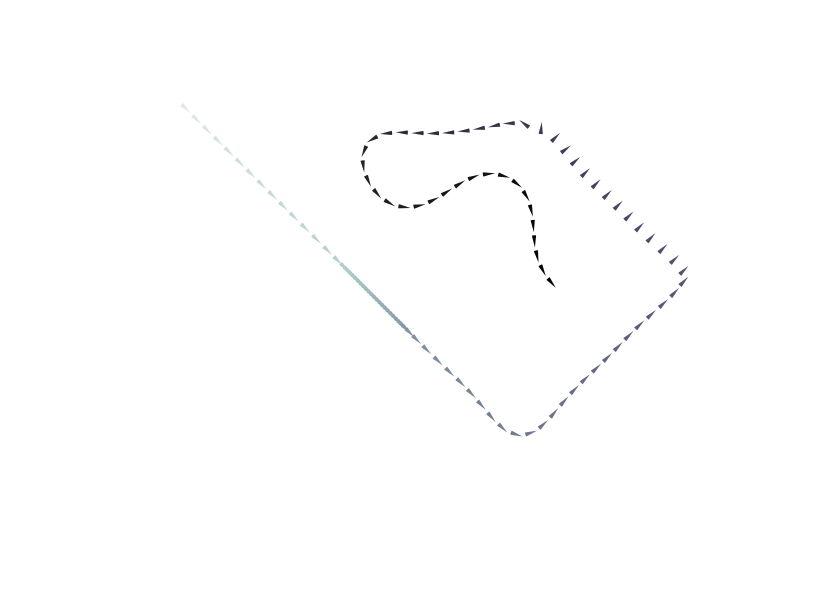

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3 * 1, 3 * 1), sharex=True, sharey=True, dpi=300)

ff.plot_trajectory(x_sim['x'], x_sim['y'], x_sim['psi'],
                   color=t_sim,
                   ax=ax,
                   size_radius=0.08,
                   nskip=0)

fifi.mpl_functions.adjust_spines(ax, [])


# if you want to use to optimize 

In [ ]:
# initial PARAMS (defaults)
BASE = {
    'g': 9.81,
    'm': 0.086,
    'M': 2.529,
    'Mm': 4*0.086 + 2.529,
    'L': 0.2032,
    'R': 0.1778,
    'I_x': 0.491,
    'I_y': 0.387,
    'I_z': 0.667,
    'b': 1.34,
    'd': 1.0,
    'C': 0.1
}

# get real PWM data but for now # use the simulated controls plus some noise and offsets
PWM_1 = u_sim['PWM1'] + np.random.normal(0, 0.01, len(u_sim['PWM1'])) + 100
PWM_2 = u_sim['PWM2'] + np.random.normal(0, 0.01, len(u_sim['PWM2'])) + 100
PWM_3 = u_sim['PWM3'] + np.random.normal(0, 0.01, len(u_sim['PWM3'])) + 100
PWM_4 = u_sim['PWM4'] + np.random.normal(0, 0.01, len(u_sim['PWM4'])) + 100
def objective(p):
    # unpack
    I_x, I_y, I_z= p

    # build a fresh PARAMS dict
    params = BASE.copy()
    params.update({'I_x': I_x,
                   'I_y': I_y,
                   'I_z': I_z})

    # instantiate simulator
    sim = DroneSimulator(
        dt=dt,
        mpc_horizon=50,
        r_u=1e-4,
        control_mode='velocity_body_level',
        params=params
    )

    # set the trajectory
    sim.update_setpoint(
        v_x=v_x,
        v_y=v_y,
        psi=psi,
        z=z,
        wx=np.zeros_like(z),
        wy=np.zeros_like(z)
    )

    # run the MPC rollout (downsample via nth inside RMSE)
    _, _, u_sim, _ = sim.simulate(
        x0=X0_sim,
        mpc=True,
        return_full_output=True
    )

    # recompute controls from PWM
    Lx = 2 * params['L'] / np.sqrt(2)
    u_thrust_sim = params['b'] * (u_sim['PWM1'] + u_sim['PWM2'] +
                                  u_sim['PWM3'] + u_sim['PWM4'])
    u_phi_sim    = params['b'] * Lx * (-u_sim['PWM1'] + u_sim['PWM2'] +
                                       u_sim['PWM3'] - u_sim['PWM4'])
    u_theta_sim  = params['b'] * Lx * (-u_sim['PWM1'] + u_sim['PWM2'] -
                                       u_sim['PWM3'] + u_sim['PWM4'])
    u_psi_sim    = params['d'] * (-u_sim['PWM1'] - u_sim['PWM2'] +
                                  u_sim['PWM3'] + u_sim['PWM4'])

    # the “real” controls computed from your logged PWM arrays
    u_thrust_real = params['b'] * (PWM_1 + PWM_2 + PWM_3 + PWM_4)
    u_phi_real    = params['b'] * Lx * (-PWM_1 + PWM_2 + PWM_3 - PWM_4)
    u_theta_real  = params['b'] * Lx * (-PWM_1 + PWM_2 - PWM_3 + PWM_4)
    u_psi_real    = params['d'] * (-PWM_1 - PWM_2 + PWM_3 + PWM_4)

    # helper to compute RMSE with downsampling
    def rmse(a, b):
        return np.sqrt(np.mean((a - b)**2))

    # collect all RMSEs
    rmses = [
        rmse(PWM_1, u_sim['PWM1']),
        rmse(PWM_2, u_sim['PWM2']),
        rmse(PWM_3, u_sim['PWM3']),
        rmse(PWM_4, u_sim['PWM4']),
        # rmse(u_thrust_real, u_thrust_sim),
        # rmse(u_phi_real,    u_phi_sim),
        # rmse(u_theta_real,  u_theta_sim),
        rmse(u_psi_real,    u_psi_sim),
    ]

    # sum them (you can instead weight or pick a subset)
    return np.sum(rmses)


if __name__ == '__main__':
    # initial guess: defaults from BASE
    p0 = np.array([BASE['I_x'], BASE['I_y'], BASE['I_z']])

    # bounds to keep things physical
    bounds = [
        (0.1, 2.0),    # I_x
        (0.1, 2.0),    # I_y
        (0.1, 2.0),    # I_z
    ]

    result = minimize(
        objective,
        x0=p0,
        bounds=bounds,
        method='L-BFGS-B',
        options={'disp': True, 'maxiter': 5}
    )

    print("Success:", result.success)
    print("Estimated [I_x, I_y, I_z]:", result.x)
    print("Final cost (sum RMSE):", result.fun)

Drone parameters: {'g': 9.81, 'm': 0.086, 'M': 2.529, 'Mm': 2.8729999999999998, 'L': 0.2032, 'R': 0.1778, 'I_x': 0.491, 'I_y': 0.387, 'I_z': 0.667, 'b': 1.34, 'd': 1.0, 'C': 0.1}
Drone parameters: {'g': 9.81, 'm': 0.086, 'M': 2.529, 'Mm': 2.8729999999999998, 'L': 0.2032, 'R': 0.1778, 'I_x': 0.49100001, 'I_y': 0.387, 'I_z': 0.667, 'b': 1.34, 'd': 1.0, 'C': 0.1}
Drone parameters: {'g': 9.81, 'm': 0.086, 'M': 2.529, 'Mm': 2.8729999999999998, 'L': 0.2032, 'R': 0.1778, 'I_x': 0.491, 'I_y': 0.38700001, 'I_z': 0.667, 'b': 1.34, 'd': 1.0, 'C': 0.1}
